# Introduction

This notebook shows usage of the xaitk-saliency API to gain insight into the behavior of a trained deep reinforcement learning agent in an Atari 2600 environment.

This example is based on [this paper](https://arxiv.org/abs/1711.00138) and the corresponding code in this [Github repository](https://github.com/greydanus/visualize_atari). The authors use the Asynchronous Advantage Actor Critic (A3C) algorithm with a LSTM-CNN policy network to train several agents for automated gameplay in different Atari 2600 games. They also implement a method for generating saliency maps using image perturbation. Here, we will try to reproduce their results using the xaitk-saliency API, focusing on the Breakout-v0 environment.

### Table of Contents
* [Set Up Environment](#Set-Up-Environment)
* [Create Atari Environment](#Create-Atari-Environment)
    * [Define Policy Network](#Define-Policy-Network)
    * [Download Pretrained Model](#Download-Pretrained-Model)
    * [Define Rollout Function](#Define-Rollout-Function)
    * [Play Breakout](#Play-Breakout)
* [Defining the Application](#Defining-the-Application)
    * [Perturbation and Saliency Implementations](#Perturbation-and-Saliency-Implementations)
    * [Calling the Application](#Calling-the-Application)

#### References
1. Greydanus, Samuel, et al. "Visualizing and Understanding Atari Agents." International Conference on Machine Learning. PMLR, 2018.

<br>

To run this notebook in Colab, please use the link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/XAITK/xaitk-saliency/blob/master/examples/atari_deepRL_saliency.ipynb)

# Set Up Environment

In [1]:
!pip install -qU pip
!pip install -q xaitk-saliency
!pip install -q "torch==1.9.0"
!pip install -q "torchvision==0.10.0"
!pip install -q "gym[atari]==0.19.0"
!pip install -q "opencv-python"

# Create Atari Environment

Here we create the Breakout environment for our agent using Gym.

Our agent has 4 different actions to choose from:
<br>&nbsp;&nbsp;&nbsp;&nbsp;1. Do nothing
<br>&nbsp;&nbsp;&nbsp;&nbsp;2. Fire
<br>&nbsp;&nbsp;&nbsp;&nbsp;3. Move right
<br>&nbsp;&nbsp;&nbsp;&nbsp;4. Move left

In [2]:
import gym

env_name = "Breakout-v0"
env = gym.make(env_name)
# Set seed for reproducibility
env.seed(1)

action_space = env.unwrapped.get_action_meanings()
print(f"Action space: {action_space}")

Action space: ['NOOP', 'FIRE', 'RIGHT', 'LEFT']


## Define Policy Network

This policy network implementation is taken directly from the author's original implementation. It consists of four convolutional layers, an LSTM layer, and two separate fully-connected layers for the value and policy function predictions.

In [3]:
import glob
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

class NNPolicy(torch.nn.Module):  # an actor-critic neural network
    def __init__(self, channels, num_actions):
        super(NNPolicy, self).__init__()
        self.conv1 = nn.Conv2d(channels, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.lstm = nn.LSTMCell(32 * 5 * 5, 256)
        self.critic_linear, self.actor_linear = nn.Linear(256, 1), nn.Linear(
            256, num_actions
        )

    def forward(self, inputs):
        inputs, (hx, cx) = inputs
        x = F.elu(self.conv1(inputs))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = F.elu(self.conv4(x))
        x = x.view(-1, 32 * 5 * 5)
        hx, cx = self.lstm(x, (hx, cx))
        return self.critic_linear(hx), self.actor_linear(hx), (hx, cx)

    def try_load(self, save_dir, checkpoint="*.tar"):
        paths = glob.glob(save_dir + checkpoint)
        step = 0
        if len(paths) > 0:
            ckpts = [int(s.split(".")[-2]) for s in paths]
            ix = np.argmax(ckpts)
            step = ckpts[ix]
            self.load_state_dict(torch.load(paths[ix]))
        print("\tno saved models") if step == 0 else print(
            "\tloaded model: {}".format(paths[ix])
        )
        return step

## Download Pretrained Model

The authors provide pretrained agents [here](https://goo.gl/fqwJDB) for the different environments they used (both the "strong" and "overfit" variants, see the original paper for details). We will use the "strong" Breakout agent for our purposes.

We provide the Breakout model checkpoint here for easy download, although we refer the reader to the link above which contains a zip file of all the pretrained agents, including both "strong" and "overfit" agents.

In [4]:
import os
import urllib.request

root_dir = 'data/pretrained_agents/breakout-v0/'
os.makedirs(root_dir, exist_ok=True)
model_checkpoint = os.path.join(root_dir, 'strong.40.tar')

_ = urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1b0NEZop09_EGTSiPalAl_I-a6ZHWz0vG', model_checkpoint)

## Load Pretrained Model

Here we load the downloaded model into an instance of the policy function class.

In [5]:
model = NNPolicy(channels=1, num_actions=env.action_space.n)
model.try_load(root_dir, checkpoint='*.tar')
# Seed seed for reproducibility
_ = torch.manual_seed(1)

	loaded model: pretrained_agents/breakout-v0/strong.40.tar


## Define Rollout Function

This function carries out the pretrained agent's policy for a defined number of frames in our Breakout environment. At each step, the current game frame is run through our policy model to get the predicted best action and the agent takes that action. The state of the game is stored after after each step.

In [6]:
import cv2


def prepro(img):
    "Standard frame pre-processing based on Greydanus et al., '18'"
    return cv2.resize(
        src=img[35:195].mean(2),
        dsize=(80, 80)
    ).astype(np.float32) / 255.0


def rollout(model, env, max_ep_len):
    history = {"ins": [], "logits": [], "values": [], "outs": [], "hx": [], "cx": []}

    state = torch.Tensor(prepro(env.reset()))  # get first state
    episode_length, epr, eploss, done = 0, 0, 0, False  # bookkeeping
    hx, cx = torch.zeros(1, 256), torch.zeros(1, 256)

    # iterate through each frame in episode
    while not done and episode_length <= max_ep_len:
        episode_length += 1
        
        # get game state
        model_inp = (state.view(1, 1, 80, 80), (hx, cx))
        
        # run through model
        value, logit, (hx, cx) = model(model_inp)
        hx, cx = hx.data, cx.data
        
        # action probabilities
        prob = F.softmax(logit)

        # best action
        action = prob.max(1)[1].data
        
        # take best action
        obs, reward, done, expert_policy = env.step(action.numpy()[0])

        # update reward
        state = torch.Tensor(prepro(obs))
        epr += reward

        # save state
        history["ins"].append(obs) # game state after taking action
        history["hx"].append(hx.squeeze(0).data.numpy()) # LSTM hx output
        history["cx"].append(cx.squeeze(0).data.numpy()) # LSTM cx output
        history["logits"].append(logit.data.numpy()[0]) # actor output
        history["values"].append(value.data.numpy()[0]) # critic output
        history["outs"].append(prob.data.numpy()[0]) # action probabilities
        print("\tstep # {}, reward {:.0f}".format(episode_length, epr), end="\r")

    return history

## Play Breakout

Our pretrained agent will now play the game for up to 3,000 frames. We will create a short video clip from a slice of the game state so we can see the agent in action. The agent shows a "tunneling" behavior, which was also noted by the original authors in the paper referenced above.

In [7]:
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Play game
print("Rolling out policy...")
history = rollout(model, env, max_ep_len=3e3)

# Create video from frames
print("\nCreating video...")
fps = 30
w = history['ins'][0].shape[1]
h = history['ins'][0].shape[0]
out = cv2.VideoWriter("data/breakout.mp4", cv2.VideoWriter_fourcc(*'vp09'), fps, (w,h))

start_frame = 1020
end_frame = 1620
for i in range(start_frame, end_frame+1):
    frame = cv2.cvtColor(history['ins'][i], cv2.COLOR_RGB2BGR) # Convert to BRG for cv2 standards
    out.write(frame)
out.release()

print("Done")

Rolling out policy...
	step # 2179, reward 258
Creating video...
Done


Here we show a single frame from the game.

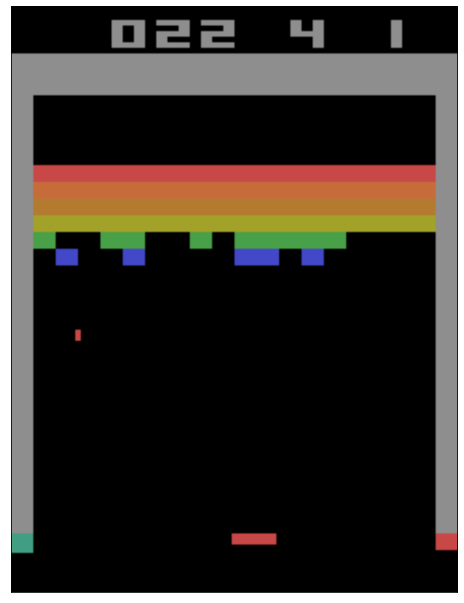

In [8]:
f = plt.figure(figsize=[8,12])
frame_ix = 1070
plt.imshow(history['ins'][frame_ix])
for a in f.axes: a.get_xaxis().set_visible(False) ; a.get_yaxis().set_visible(False)
plt.show(f)

Here we show a recorded video from the game. This video is saved as `breakout.mp4` in the current directory.

In [9]:
%%HTML
<div align="middle">
<video width="50%" controls>
      <source src="data/breakout.mp4" type="video/mp4">
</video></div>

# Defining the Application

Our saliency application has four parameters:
<br>&nbsp;&nbsp;&nbsp;&nbsp;`start_frame` - the first frame to perform saliency generation for
<br>&nbsp;&nbsp;&nbsp;&nbsp;`end_frame` - the last frame to perform saliency generation for
<br>&nbsp;&nbsp;&nbsp;&nbsp;`perturber` - the PerturbImage implementation to use
<br>&nbsp;&nbsp;&nbsp;&nbsp;`saliency_gen` - the GenerateClassifierConficdenceSaliency implementation to use

Note that here we create a specific `PolicyScoring` implementation of the `GenerateClassifierConfidenceSaliency` interface, which allows us to generate the actor and critic saliency maps. Although the policy network is not an image classification model per se, it shares certain similarities in that it also receives as input an image (i.e. a video game frame) and outputs vectors of action and/or value scores which are similar to classifier confidences. The implementation here closely follows the original implementation given in [Greydanus et al., '18](https://arxiv.org/abs/1711.00138).

The application will create saliency maps for both the actor (policy function) and the critic (value function) for each frame from `start_frame` to `end_frame` using the image perturber and saliency generator that you pass it. Salient parts of each frame will be highlighted in blue for the actor and in red for the critic and a video will be created from this set of highlighted game frames. This gives a single representation for each frame of where both models are looking to make their predictions.

To speed up this process, the application utilizes multiple processing threads, one for each frame. This will use a good amount of system memory so be cautious.

In [10]:
from xaitk_saliency import PerturbImage, GenerateClassifierConfidenceSaliency
from xaitk_saliency.utils.masking import occlude_image_batch, weight_regions_by_scalar
from scipy.ndimage.filters import gaussian_filter

import threading
import concurrent.futures
import multiprocessing

actor_sal_maps = []
critic_sal_maps = []

print_lock = threading.Lock() # Lock to control thread printing


def postprocess_sal(sal, ff):
    """
    Helper function for post-processing saliency maps, which includes resizing
    the saliency maps to (160,160) and multiplying them by a "fudge factor" ff
    as in the original implementation.
    """
    pmax = sal.max()
    sal = cv2.resize(src=sal, dsize=(160,160)).astype(np.float32)
    sal -= sal.min()
    sal = ff * pmax * sal / sal.max()
    
    return sal


class PolicyScoring(GenerateClassifierConfidenceSaliency):
    """
    This saliency implementation transforms black-box action and value scores
    from an actor-critic policy network into saliency heatmaps. This should
    require a sequence of either action scores or values scores predicted on
    the reference image, a number of action or values scores predicted on
    perturbed images, as well as the masks of the reference image perturbations
    (as would be output from a `PerturbImage` implementation).
    
    Note that here the returned saliency maps are not normalized to the range
    [-1,1], as this is currently done by a saliency post-processing function.
    
    Based on Greydanus et. al:
    https://arxiv.org/abs/1711.00138
    """
    def generate(self,
                 reference: np.ndarray,
                 perturbed: np.ndarray,
                 perturbed_masks: np.ndarray
    ) -> np.ndarray:

        # Based on equations 2 and 4 from Greydanus et al., '18
        diff = 1/2*((reference - perturbed)**2).sum(axis=1, keepdims=True)
        sal = weight_regions_by_scalar(diff, perturbed_masks)[0]
        
        return sal
    
    def get_config(self) -> dict:
        return {}


def gen_sal_maps(img_idx, sal_idx, perturber, saliency_gen, verbose=0):
    """
    Generates actor and critic saliency maps on a per-frame basis given an image
    perturber and a saliency map generation implementation.
    
    img_idx: index of input video frame
    sal_idx: index into corresponding global saliency map arrays
    perturber: PerturbImage implementation
    saliency_gen: GenerateClassifierConfidenceSaliency implementation
    verbose: whether or not to print debug statements (default: 0)
    """
    global actor_sal_maps
    global critic_sal_maps
    
    # Score reference frame
    if verbose:
        with print_lock:
            print(f"[{img_idx}]Scoring frame")
    
    ref_img = history['ins'][img_idx]
    ref_img_proc = prepro(ref_img)
    hx = torch.tensor(history['hx'][img_idx-1]).view(1, -1)
    cx = torch.tensor(history['cx'][img_idx-1]).view(1, -1)

    ref_img_tensor = torch.tensor(ref_img_proc.reshape(1, 1, 80, 80))
    model_inp = (ref_img_tensor, (hx, cx))
    ref_value, ref_logit, _ = model(model_inp)
    ref_value = ref_value.detach().numpy()[0]
    ref_logit = ref_logit.detach().numpy()[0]
        
    # Get image perturbations
    if verbose:
        with print_lock:
            print(f"[{img_idx}]Perturbing image")

    pert_masks = perturber(ref_img_proc)
    blurred_img = gaussian_filter(ref_img_proc, sigma=3)
    pert_imgs = occlude_image_batch(ref_img_proc, pert_masks, fill=blurred_img)

    pert_values = []
    pert_logits = []
    
    # Score perturbed frames
    if verbose:
        with print_lock:
            print(f"[{img_idx}]Scoring perturbations")

    for pert_img in pert_imgs:

        pert_img_tensor = torch.tensor(pert_img.reshape(1, 1, 80, 80))
        model_inp = (pert_img_tensor, (hx, cx))
        pert_value, pert_logit, _ = model(model_inp)
        pert_values.append(pert_value.detach().numpy()[0])
        pert_logits.append(pert_logit.detach().numpy()[0])
        
    # Generate actor saliency maps
    if verbose:
        with print_lock:
            print(f"[{img_idx}]Generating actor saliency maps")
    
    actor_sal_maps[sal_idx] = saliency_gen(ref_logit, pert_logits, pert_masks)
        
    # Generate critic saliency maps
    if verbose:
        with print_lock:
            print(f"[{img_idx}]Generating critic saliency maps")
    
    critic_sal_maps[sal_idx] = saliency_gen(ref_value, pert_values, pert_masks)


def app(
    start_frame: int,
    end_frame: int,
    perturber: PerturbImage,
    saliency_gen: GenerateClassifierConfidenceSaliency
):
    global actor_sal_maps
    global critic_sal_maps
    
    # Initialize map arrays to correct size
    actor_sal_maps = [None] * (end_frame - start_frame +1)
    critic_sal_maps = [None] * (end_frame - start_frame +1)
    
    # Use threaded computation
    call_wrapper = lambda idx: gen_sal_maps(idx, idx-start_frame, perturber, saliency_gen)
    tpe = concurrent.futures.ThreadPoolExecutor(max_workers=multiprocessing.cpu_count())
    list(tpe.map(call_wrapper, range(start_frame, end_frame+1)))
    tpe.shutdown(wait=True)
    
    # Write out videos
    print("Creating video")
    fps = 30
    vid_writer = cv2.VideoWriter("data/breakout_saliency.mp4", cv2.VideoWriter_fourcc(*'vp09'), fps, (w,h))
    
    for img_idx in range(start_frame, end_frame+1):
        sal_idx = img_idx-start_frame
        
        # Post-processing here follows Greydanus et al., '18
        img = history['ins'][img_idx].copy().astype('uint16')
        
        # Highlight actor saliency in blue and critic saliency in red
        img[35:195,:,2] += postprocess_sal(actor_sal_maps[sal_idx], 300).astype('uint16')
        img[35:195,:,0] += postprocess_sal(critic_sal_maps[sal_idx], 600).astype('uint16')
        
        img = img.clip(1,255).astype('uint8')
        frame = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # Convert to BGR to meet cv2 convention
        
        vid_writer.write(frame)
        
    vid_writer.release()
    
    print("Done.")

## Perturbation and Saliency Implementations

For this example we will use the `SlidingRadial` perturbation implementation with blurring using sigma values of (5,5) and stride of (5,5). Our filled image here will be a blurred version of the original image. We try to use the same parameters as in the original implementation.

The `PolicyScoring` heatmap generation implementation (defined above) is appropriate here as both the actor and critic are classification-like models.

In [11]:
from xaitk_saliency.impls.perturb_image.sliding_radial import SlidingRadial

window_perturber = SlidingRadial(radius=(1,1), stride=(5,5), sigma=(5,5))
sal_gen = PolicyScoring()

## Calling the Application

An arbitrary set of frames is chosen for saliency generation using our application and the resulting video is displayed below.

From the video it is apparent that the area above the paddle and around the ball seem to be very important to both the value and policy functions. We can also see that the value function is heavily affected by holes in the blocks. This suggests that the agent has learned to create these holes so that it can get the ball behind the blocks to earn a high reward quickly.

In [12]:
app(
    start_frame=1020,
    end_frame=1620,
    perturber=window_perturber,
    saliency_gen=sal_gen
)

Creating video
Done.


Here we again show saliency (actor in blue, critic in red) overlaid on a single frame from the game.

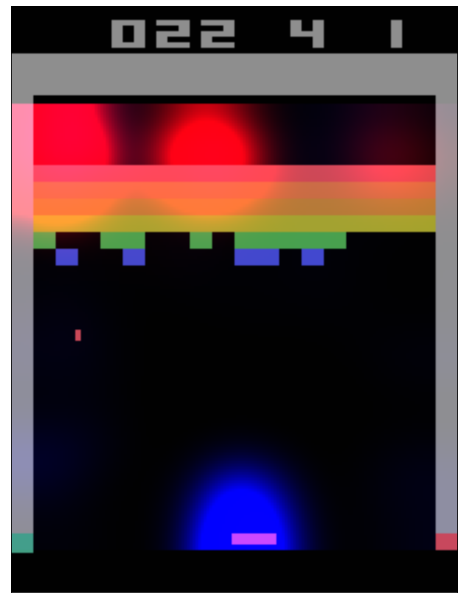

In [13]:
f = plt.figure(figsize=[8,12])
frame_ix = 1070

img = history['ins'][frame_ix].copy().astype('uint16')

# Highlight actor saliency in blue and critic saliency in red
img[35:195,:,2] += postprocess_sal(actor_sal_maps[frame_ix-1020], 300).astype('uint16')
img[35:195,:,0] += postprocess_sal(critic_sal_maps[frame_ix-1020], 600).astype('uint16')
img = img.clip(1,255).astype('uint8')

plt.imshow(img)

for a in f.axes: a.get_xaxis().set_visible(False) ; a.get_yaxis().set_visible(False)
plt.show(f)

Finally, we show a recorded video from the game with overlaid saliency (actor in blue, critic in red). This video is saved as `breakout_saliency.mp4` in the current directory.

In [14]:
%%HTML
<div align="center">
<video width="50%" controls>
    <source src="data/breakout_saliency.mp4" type="video/mp4">
</video>
</div>